<a href="https://colab.research.google.com/github/Jacob-Lang/GPU-Neural-Network/blob/master/Convolutional_Neural_Network_CPU_vs_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network: CPU vs GPU

Google Colab has a free GPU so I want to see how much speed-up it provides over the CPU for neural network training.

As an example problem I will train a convolutional neural network to classify photos from 6 classes: Buildings, Forest, Glacier, Mountain, Sea, Street.

The data for this classification problem can be found here:
https://www.kaggle.com/puneet6060/intel-image-classification




## Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras import backend as K  # for GPU
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix

import time

from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Importing the data

Copying files from google drive to colab is very slow so to speed up the process I will unzip the data file from my drive directly into the colab working directory.

In [ ]:
## Unzip directly into colab. This provides massive speed up later as copying from drive to colab is slow.
zip_path = '/content/drive/My Drive/Notebooks/intel-image-classification.zip'
!cp "{zip_path}" .
!unzip -n -q intel-image-classification.zip
!rm intel-image-classification.zip

The dataset is large so to avoid loading the whole lot from disk to RAM I will use the ImageDataGenerator from Keras. This sequentially loads the data (batch by batch) from disk during training and evaluation. 

In [ ]:
# create generator
datagen_train = ImageDataGenerator(rescale=1.0/255)  # this used for training data
datagen_testval = ImageDataGenerator(rescale=1.0/255, validation_split = 0.5) # split test set into test and val 50/50

# prepare an iterators for each dataset
train_it = datagen_train.flow_from_directory('seg_train/seg_train/', class_mode='categorical', target_size = (150,150), batch_size=32,)
test_it = datagen_testval.flow_from_directory('seg_test/seg_test/', class_mode='categorical', target_size = (150,150), batch_size=32, subset='training', shuffle='False') # subset determines which portion of split
val_it = datagen_testval.flow_from_directory('seg_test/seg_test/', class_mode='categorical', target_size = (150,150), batch_size=32, subset='validation')

# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 14034 images belonging to 6 classes.
Found 1502 images belonging to 6 classes.
Found 1498 images belonging to 6 classes.
Batch shape=(32, 150, 150, 3), min=0.000, max=1.000


## Inspecting the data

In [ ]:
## helper function to decode network output
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] # poss categories
def decode_output(y):
    """
    Decodes output array to predicted category
    Inputs: y - a shape (6,) numpy array.
    Outputs: prediction - a string name of the predicted category.
    """
    
    index = np.argmax(y) # find entry with largest element
    prediction = categories[index] # this determines prediciton
    
    return prediction

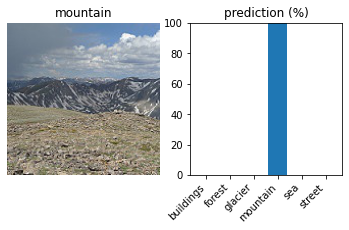

In [ ]:
## plot an image with its label
n = 10
image = batchX[n]
label_array = (100*batchy[n]).astype(int) # in percentage
label = decode_output(batchy[n])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)  
ax[0].set_title(label)
ax[0].axis('off')

ax[1].bar(categories,label_array)
ax[1].set_ylim(0,100)
ax[1].set_aspect(1./ax[1].get_data_ratio())  # set axes to square
ax[1].set_xticklabels(categories, rotation=45, ha="right");  # rotate and align category labels
ax[1].set_title('prediction (%)');

## Build the model

My CNN will have 3 convolutional layers with max pooling and dropout. The final layer will be a dense layer with 6 neurons. I use categorical crossentropy as a loss so that the output can represent the probabilities of each class.  

In [ ]:
def create_model():
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
  model.add(Dropout(0.2))

  model.add(MaxPool2D(pool_size = (4,4)))

  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(Dropout(0.2))

  model.add(MaxPool2D(pool_size = (4,4)))

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(Dropout(0.2))

  model.add(MaxPool2D(pool_size = (4,4)))

  model.add(Flatten())

  model.add(Dense(6, activation='softmax'))

  # compile
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# view model structure
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)        

## Training CPU vs GPU

To observe the speed-up from using a GPU I will train the network over the whole dataset for 1 epoch.

In [ ]:
## How long to train over 1 epoch

model = create_model()
with tf.device('/device:CPU:0'):
  #train the model
  t1 = time.time()
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=1)
  dt = time.time() - t1
  print('The CPU trained over 1 epoch in ', dt, ' seconds.')

model = create_model()
with tf.device('/device:GPU:0'):
  #train the model
  t1 = time.time()
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=1)
  dt = time.time() - t1
  print('The GPU trained over 1 epoch in ', dt, ' seconds.')

Epoch 1/1
439/439 [==============================] - 348s 792ms/step - loss: 1.0881 - accuracy: 0.5676
The CPU trained over 1 epoch in  348.3272452354431  seconds.
Epoch 1/1
439/439 [==============================] - 28s 64ms/step - loss: 1.0197 - accuracy: 0.5980
The GPU trained over 1 epoch in  28.644651412963867  seconds.


The GPU offers a significant speed up. In this test it is over 10x faster than the CPU!

## Exploiting the GPU

Now I will use this fast GPU train the network over more epochs to see how well it performs.

In [ ]:
model = create_model()
with tf.device('/device:GPU:0'):
  #train the model
  t1 = time.time()
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=25, validation_data=val_it, validation_steps=32)
  dt = time.time() - t1
  print('This took:', dt, ' seconds.')

Epoch 1/25
439/439 [==============================] - 24s 54ms/step - loss: 1.0648 - accuracy: 0.5807 - val_loss: 1.0945 - val_accuracy: 0.6445
Epoch 2/25
439/439 [==============================] - 23s 52ms/step - loss: 0.7823 - accuracy: 0.7067 - val_loss: 1.0866 - val_accuracy: 0.7308
Epoch 3/25
439/439 [==============================] - 23s 52ms/step - loss: 0.6806 - accuracy: 0.7486 - val_loss: 0.7705 - val_accuracy: 0.7544
Epoch 4/25
439/439 [==============================] - 23s 52ms/step - loss: 0.6234 - accuracy: 0.7716 - val_loss: 0.7661 - val_accuracy: 0.7793
Epoch 5/25
439/439 [==============================] - 23s 52ms/step - loss: 0.5812 - accuracy: 0.7879 - val_loss: 0.7625 - val_accuracy: 0.7623
Epoch 6/25
439/439 [==============================] - 23s 52ms/step - loss: 0.5403 - accuracy: 0.8041 - val_loss: 0.6272 - val_accuracy: 0.7760
Epoch 7/25
439/439 [==============================] - 23s 53ms/step - loss: 0.5115 - accuracy: 0.8124 - val_loss: 0.8680 - val_accuracy:

This took ~ 10 minutes. The CPU would have taken over 1.5 hours!

## Learning curve

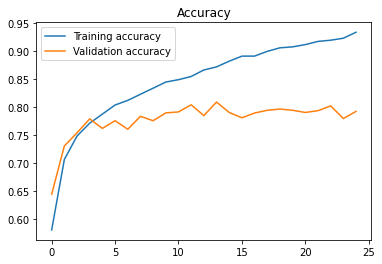

In [ ]:
plt.figure()
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.legend(loc='best');

The validation accuracy peaks after about 5 epochs. Whilst the training accuracy continues to increase this is an indication that the model is just memorising the data set. To increase the performance of the model it would be necessary to change the hyperparameters: e.g. add more layers. 

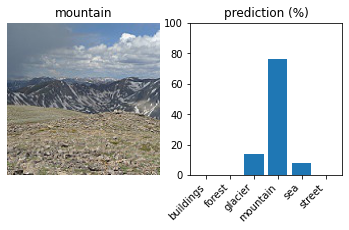

In [ ]:
y = model.predict(image.reshape((1,*image.shape)))[0]

label_array = (100*y).astype(int) # in percentage
label = decode_output(batchy[n])
### plot multiple here

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)  #.transpose(2,1,0]
ax[0].set_title(label)
ax[0].axis('off')

ax[1].bar(categories,label_array)
ax[1].set_ylim(0,100)
ax[1].set_aspect(1./ax[1].get_data_ratio())  # set axes to square
ax[1].set_xticklabels(categories, rotation=45, ha="right");  # rotate and align category labels
ax[1].set_title('prediction (%)');

Classification Report
              precision    recall  f1-score   support

   buildings       0.71      0.82      0.76       219
      forest       0.95      0.95      0.95       237
     glacier       0.78      0.84      0.81       277
    mountain       0.88      0.60      0.71       263
         sea       0.70      0.94      0.81       255
      street       0.89      0.69      0.78       251

    accuracy                           0.81      1502
   macro avg       0.82      0.81      0.80      1502
weighted avg       0.82      0.81      0.80      1502



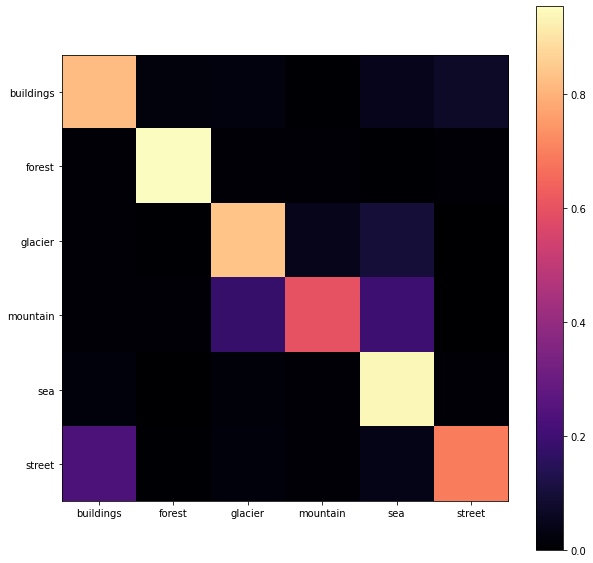

In [ ]:
#Confusion Matrix and Classification Report

Y_pred = model.predict_generator(test_it, steps=len(test_it))
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_it.classes[test_it.index_array]
cm = confusion_matrix(y_true, y_pred,normalize='true')

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=categories))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, cmap='magma')
fig.colorbar(im, ax=ax)
ax.set_xticklabels([0] + categories)
ax.set_yticklabels([0] + categories);

The confusion matrix shows us that the model may struggle to distinguish Buildings and Streets and Glacier and Mountain. These pairs can look quite similar so the confusion is understandable. 

## Conclusion

We have seen that the GPU offered by Google Colab provides a massive speed up in training neural networks. However, this does not replace the need for good hyperparameter tuning.

## Saving model to disk

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

from keras.models import model_from_json

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


## Additional: Swish vs ReLU activation function

After reading this article: https://medium.com/analytics-vidhya/swish-booting-relu-from-the-activation-function-throne-78f87e5ab6eb I want to test the training time and performance of a different activation function - swish. I will compare the results with the CNN using ReLU above.

In [ ]:
# Define swish activation
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

# Register with keras
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# Build same model as before but with swish instead of relu. (still use softmax for final layer)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='swish', input_shape=(150,150,3)))
model.add(Dropout(0.2))

model.add(MaxPool2D(pool_size = (4,4)))

model.add(Conv2D(64, kernel_size=(3,3), activation='swish'))
model.add(Dropout(0.2))

model.add(MaxPool2D(pool_size = (4,4)))

model.add(Conv2D(128, kernel_size=(3,3), activation='swish'))
model.add(Dropout(0.2))

model.add(MaxPool2D(pool_size = (4,4)))

model.add(Flatten())

model.add(Dense(6, activation='softmax'))

# compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# view model structure
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
dropout_7 (Dropout)          (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 35, 35, 64)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)        

In [ ]:
# Train on GPU
with tf.device('/device:GPU:0'):
  #train the model
  t1 = time.time()
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=25, validation_data=val_it, validation_steps=32)
  dt = time.time() - t1
  print('This took:', dt, ' seconds.')

Epoch 1/25
439/439 [==============================] - 25s 56ms/step - loss: 1.1715 - accuracy: 0.5318 - val_loss: 1.2644 - val_accuracy: 0.4854
Epoch 2/25
439/439 [==============================] - 24s 55ms/step - loss: 0.8962 - accuracy: 0.6649 - val_loss: 1.6882 - val_accuracy: 0.4961
Epoch 3/25
439/439 [==============================] - 24s 55ms/step - loss: 0.7703 - accuracy: 0.7121 - val_loss: 0.8677 - val_accuracy: 0.5442
Epoch 4/25
439/439 [==============================] - 24s 55ms/step - loss: 0.7041 - accuracy: 0.7416 - val_loss: 1.2279 - val_accuracy: 0.5645
Epoch 5/25
439/439 [==============================] - 24s 55ms/step - loss: 0.6504 - accuracy: 0.7626 - val_loss: 1.3333 - val_accuracy: 0.5668
Epoch 6/25
439/439 [==============================] - 25s 56ms/step - loss: 0.6229 - accuracy: 0.7693 - val_loss: 2.6171 - val_accuracy: 0.4686
Epoch 7/25
439/439 [==============================] - 25s 56ms/step - loss: 0.5738 - accuracy: 0.7885 - val_loss: 2.2750 - val_accuracy:

This took ~ 10 minutes. The CPU would have taken over 1.5 hours!

## Learning curve

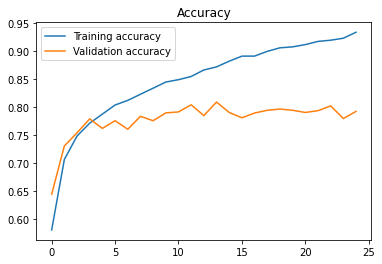

In [ ]:
plt.figure()
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.legend(loc='best');

The validation accuracy peaks after about 5 epochs. Whilst the training accuracy continues to increase this is an indication that the model is just memorising the data set. To increase the performance of the model it would be necessary to change the hyperparameters: e.g. add more layers. 

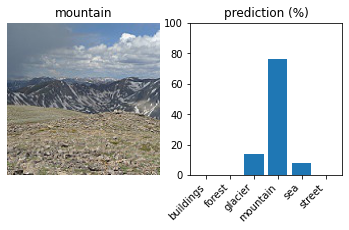

In [ ]:
y = model.predict(image.reshape((1,*image.shape)))[0]

label_array = (100*y).astype(int) # in percentage
label = decode_output(batchy[n])
### plot multiple here

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)  #.transpose(2,1,0]
ax[0].set_title(label)
ax[0].axis('off')

ax[1].bar(categories,label_array)
ax[1].set_ylim(0,100)
ax[1].set_aspect(1./ax[1].get_data_ratio())  # set axes to square
ax[1].set_xticklabels(categories, rotation=45, ha="right");  # rotate and align category labels
ax[1].set_title('prediction (%)');

Classification Report
              precision    recall  f1-score   support

   buildings       0.71      0.82      0.76       219
      forest       0.95      0.95      0.95       237
     glacier       0.78      0.84      0.81       277
    mountain       0.88      0.60      0.71       263
         sea       0.70      0.94      0.81       255
      street       0.89      0.69      0.78       251

    accuracy                           0.81      1502
   macro avg       0.82      0.81      0.80      1502
weighted avg       0.82      0.81      0.80      1502



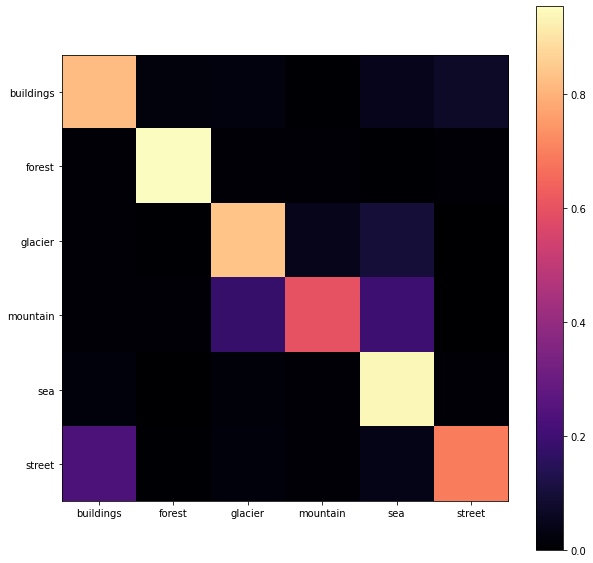

In [ ]:
#Confusion Matrix and Classification Report

Y_pred = model.predict_generator(test_it, steps=len(test_it))
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_it.classes[test_it.index_array]
cm = confusion_matrix(y_true, y_pred,normalize='true')

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=categories))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, cmap='magma')
fig.colorbar(im, ax=ax)
ax.set_xticklabels([0] + categories)
ax.set_yticklabels([0] + categories);

Training with swish activation actually produced very similar results to ReLU. But it took twice as long. Whilst using swish has been shown to improve on ReLU in some situations clearly it is not just an easy gain and this benefit will only be provided in specific cases. 